# Degradation and soiling example with clearsky workflow


This jupyter notebook is intended to the RdTools analysis workflow.  In addition, the notebook demonstrates the effects of changes in the workflow. For a consistent experience, we recommend installing the specific versions of packages used to develop this notebook. This can be achieved in your environment by running `pip install -r requirements.txt` followed by `pip install -r docs/notebook_requirements.txt` from the base directory. (RdTools must also be separately installed.)

The calculations consist of several steps illustrated here:
<ol start="0">
  <li><b>Import and preliminary calculations</b></li>
  <li><b>Normalize</b> data using a performance metric</li>
  <li><b>Filter</b> data that creates bias</li>
  <li><b>Aggregate data</b></li>
  <li> <b>Analyze</b> aggregated data to estimate the degradation rate</li>
  <li> <b>Analyze</b> aggregated data to estimate the soiling loss</li>
</ol>

After demonstrating these steps using sensor data, a modified version of the workflow is illustrated using modeled clear sky irradiance and temperature. The results from the two methods are compared at the end.

This notebook works with data from the NREL PVDAQ `[4] NREL x-Si #1` system.  Note that because this system does not experience significant soiling, the dataset contains a synthesized soiling signal for use in the soiling section of the example.  The dataset used in this example can be downloaded from [TODO](http://link.com).  Please download and unzip the csv file in the folder:
`./rdtools/docs/`

In [1]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pvlib
import rdtools
%matplotlib inline

In [2]:
#Update the style of plots
import matplotlib
matplotlib.rcParams.update({'font.size': 12,
                           'figure.figsize': [4.5, 3],
                           'lines.markeredgewidth': 0,
                           'lines.markersize': 2
                           })

In [3]:
# Set the random seed for numpy to ensure consistent results
np.random.seed(0)

## 0: Import and preliminary calculations


This section prepares the data necessary for an `rdtools` calculation. The first step of the `rdtools` workflow is normalization, which requires a time series of energy yield, a time series of cell temperature, and a time series of irradiance, along with some metadata (see Step 1: Normalize)

The following section loads the data, adjusts units where needed, and renames the critical columns. The ambient temperature sensor data source is converted into estimated cell temperature.  This dataset already has plane-of-array irradiance data, so no transposition is necessary.

A common challenge is handling datasets with and without daylight savings time. Make sure to specify a `pytz` timezone that does or does not include daylight savings time as appropriate for your dataset.

<b>The steps of this section may change depending on your data source or the system being considered.</b>  Transposition of irradiance and modeling of cell temperature are generally outside the scope of `rdtools`. A variety of tools for these calculations are available in [pvlib](https://github.com/pvlib/pvlib-python).

C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


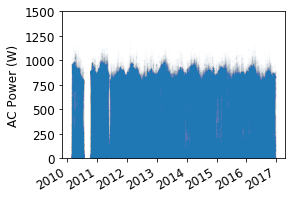

In [4]:
file_name = 'PVDAQ_system_4_2010-2016_subset_soilsignal.csv'

df = pd.read_csv(file_name, index_col=0, parse_dates=True)

df = df.rename(columns = {
    'ac_power':'power',
    'wind_speed': 'wind',
    'ambient_temp': 'Tamb',
    'poa_irradiance': 'poa',
})

# Specify the Metadata
meta = {"latitude": 39.7406,
        "longitude": -105.1774,
        "timezone": 'Etc/GMT+7',
        "tempco": -0.005,
        "azimuth": 180,
        "tilt": 40,
        "pdc": 1000.0,
        "temp_model_params":
        pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']}

df.index = df.index.tz_localize(meta['timezone'])

loc = pvlib.location.Location(meta['latitude'], meta['longitude'], tz = meta['timezone'])
sun = loc.get_solarposition(df.index)

# There is some missing data, but we can infer the frequency from
# the first several data points
freq = pd.infer_freq(df.index[:10])

# Then set the frequency of the dataframe.
# It is recommended not to up- or downsample at this step
# but rather to use interpolate to regularize the time series
# to its dominant or underlying frequency. Interpolate is not
# generally recommended for downsampling in this application.
df = rdtools.interpolate(df, freq)

# Calculate cell temperature
df['Tcell'] = pvlib.temperature.sapm_cell(df.poa, df.Tamb,
                                          df.wind, **meta['temp_model_params'])

# plot the AC power time series
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(df.index, df.power, 'o', alpha=0.01)
ax.set_ylim(0,1500)
fig.autofmt_xdate()
ax.set_ylabel('AC Power (W)');

## 1: Normalize

Data normalization is achieved with `rdtools.normalize_with_expected_power()`. This function can be used to normalize to any modeled or expected power. Note that realized PV output can be given as energy, rather than power, by using an optional key word argument. 

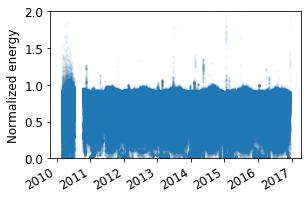

In [5]:
# Calculate the expected power with a simple PVWatts DC model
modeled_power = pvlib.pvsystem.pvwatts_dc(df['poa'], df['Tcell'], meta['pdc'],
                                          meta['tempco'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
normalized, insolation = rdtools.normalize_with_expected_power(df['power'],
                                                               modeled_power,
                                                               df['poa'])

df['normalized'] = normalized
df['insolation'] = insolation

# Plot the normalized power time series
fig, ax = plt.subplots()
ax.plot(normalized.index, normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 2: Filter

Data filtering is used to exclude data points that represent invalid data, create bias in the analysis, or introduce significant noise.

It can also be useful to remove outages and outliers. Sometimes outages appear as low but non-zero yield. Automatic functions for outage detection are not yet included in `rdtools`.  However, this example does filter out data points where the normalized energy is less than 1%.  System-specific filters should be implemented by the analyst if needed.

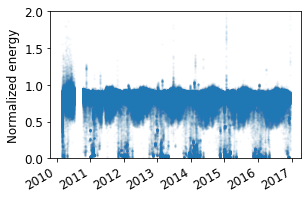

In [6]:
# Calculate a collection of boolean masks that can be used
# to filter the time series
normalized_mask = rdtools.normalized_filter(df['normalized'])
poa_mask = rdtools.poa_filter(df['poa'])
tcell_mask = rdtools.tcell_filter(df['Tcell'])
# Note: This clipping mask may be disabled when you are sure the system is not 
# experiencing clipping due to high DC/AC ratio
clip_mask = rdtools.clip_filter(df['power'])

# filter the time series and keep only the columns needed for the
# remaining steps
filtered = df[normalized_mask & poa_mask & tcell_mask & clip_mask]
filtered = filtered[['insolation', 'normalized']]

fig, ax = plt.subplots()
ax.plot(filtered.index, filtered.normalized, 'o', alpha = 0.05)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 3: Aggregate

Data is aggregated with an irradiance weighted average. This can be useful, for example with daily aggregation, to reduce the impact of high-error data points in the morning and evening.

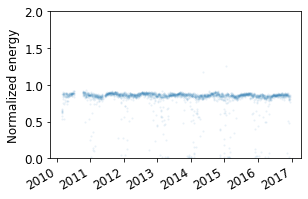

In [7]:
daily = rdtools.aggregation_insol(filtered.normalized, filtered.insolation,
                                  frequency = 'D')

fig, ax = plt.subplots()
ax.plot(daily.index, daily, 'o', alpha = 0.1)
ax.set_ylim(0,2)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

## 4: Degradation calculation

Data is then analyzed to estimate the degradation rate representing the PV system behavior. The results are visualized and statistics are reported, including the 68.2% confidence interval, and the P95 exceedance value.

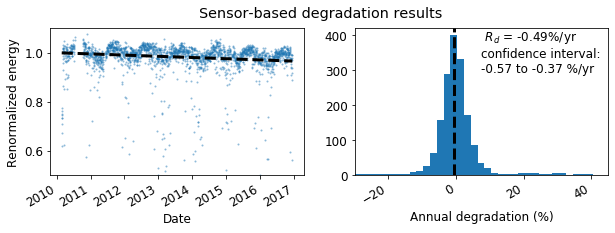

In [8]:
# Calculate the degradation rate using the YoY method
yoy_rd, yoy_ci, yoy_info = rdtools.degradation_year_on_year(daily, confidence_level=68.2)
# Note the default confidence_level of 68.2 is appropriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results

degradation_fig = rdtools.degradation_summary_plots(
    yoy_rd, yoy_ci, yoy_info, daily,
    summary_title='Sensor-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, bins=100
)

In addition to the confidence interval, the year-on-year method yields an exceedance value (e.g. P95), the degradation rate that was exceeded (slower degradation) with a given probability level. The probability level is set via the `exceedance_prob` keyword in `degradation_year_on_year`.

In [9]:
print('The P95 exceedance level is %.2f%%/yr' % yoy_info['exceedance_level'])

The P95 exceedance level is -0.65%/yr


## 5: Soiling calculations  

This section illustrates how the aggregated data can be used to estimate soiling losses using the stochastic rate and recovery (SRR) method.<sup>1</sup> Since our example system doesn't experience much soiling, we apply an artificially generated soiling signal, just for the sake of example.

<sup>1</sup>M. G. Deceglie, L. Micheli and M. Muller, "Quantifying Soiling Loss Directly From PV Yield," IEEE Journal of Photovoltaics, vol. 8, no. 2, pp. 547-551, March 2018. doi: 10.1109/JPHOTOV.2017.2784682

In [10]:
# Apply artificial soiling signal for example
# be sure to remove this for applications on real data,
# and proceed with analysis on `daily` instead of `soiled_daily`

soiling = df['soiling'].resample('D').mean()
soiled_daily = soiling*daily

In [11]:
# Calculate the daily insolation, required for the SRR calculation
daily_insolation = filtered['insolation'].resample('D').sum()

# Perform the SRR calculation
cl = 68.2
sr, sr_ci, soiling_info = rdtools.soiling_srr(soiled_daily, daily_insolation,
                                              confidence_level=cl)

In [54]:
print('The P50 insolation-weighted soiling ratio is %0.3f'%sr)
print('True insolation weighted Soiling Ratio: %0.3f'%((soiling * daily_insolation).sum() / daily_insolation.sum()))

The P50 insolation-weighted soiling ratio is 0.945
True insolation weighted Soiling Ratio: 0.960


In [13]:
print('The %0.1f confidence interval for the insolation-weighted'
      ' soiling ratio is %0.3f–%0.3f'%(cl, sr_ci[0], sr_ci[1]))

The 68.2 confidence interval for the insolation-weighted soiling ratio is 0.939–0.951


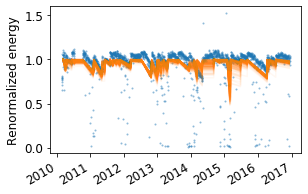

In [14]:
# Plot Monte Carlo realizations of soiling profiles
fig = rdtools.soiling_monte_carlo_plot(soiling_info, soiled_daily, profiles=200);

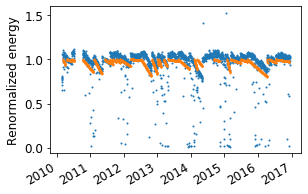

In [15]:
# Plot the slopes for "valid" soiling intervals identified,
# assuming perfect cleaning events
fig = rdtools.soiling_interval_plot(soiling_info, soiled_daily);

In [16]:
# View the first several rows of the soiling interval summary table
soiling_summary = soiling_info['soiling_interval_summary']
soiling_summary.head()

,start,end,slope,slope_low,slope_high,inferred_start_loss,inferred_end_loss,length,valid
0,2010-02-25 00:00:00-07:00,2010-03-07 00:00:00-07:00,0.000000,0.000000,0.0,0.670696,0.897587,10,False
1,2010-03-08 00:00:00-07:00,2010-03-11 00:00:00-07:00,0.000000,0.000000,0.0,1.048614,1.011925,3,False
2,2010-03-12 00:00:00-07:00,2010-04-08 00:00:00-07:00,-0.002423,-0.005208,0.0,1.058734,0.993322,27,True
3,2010-04-09 00:00:00-07:00,2010-04-11 00:00:00-07:00,0.000000,0.000000,0.0,1.045265,1.045265,2,False
4,2010-04-12 00:00:00-07:00,2010-04-20 00:00:00-07:00,0.000000,0.000000,0.0,1.036545,1.026360,8,False


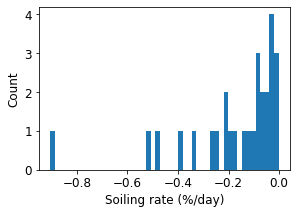

In [17]:
# View a histogram of the valid soiling rates found for the data set
fig = rdtools.soiling_rate_histogram(soiling_info, bins=50)

These plots show generally good results from the SRR method. In this example, we have slightly overestimated the soiling loss because we used the default behavior of the `method` key word argument in `rdtools.soiling_srr()`, which does not assume that every cleaning is perfect but the example artificial soiling signal did include perfect cleaning. We encourage you to adjust the options of `rdtools.soiling_srr()` for your application.

## Using CODS for combined degradation and soiling analysis

An alternative model for estimating degradation rates and soiling losses is the Combined Degradation and Soiling (CODS) method. This is an iterative self-consistent approach, where the two components, along with a seaosnal component, are estimated step-by-step, and where each new component estimate is used to improve the estimate of the other components.

CODS is more sensitive to outliers than SRR, so an intermediate step of outlier filtering is required before the algorithm is run:

Upper, lower limit 0.06699941980643964 -0.07019457880522817


C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


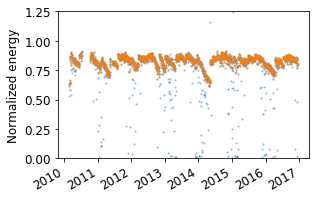

In [18]:
soiled_daily_filtered = soiled_daily.copy()
rm_soiled_daily = soiled_daily.rolling(7, 3, center=True).median()
rm_residuals = soiled_daily - rm_soiled_daily
upper_outliers, lower_outliers = rdtools.soiling.find_numeric_outliers(
    rm_residuals.dropna(), 3, verbose=True)
outliers = ~(~upper_outliers * ~lower_outliers * soiled_daily > 0.1)
soiled_daily_filtered[outliers] = np.nan

fig, ax = plt.subplots()
ax.plot(soiled_daily.index, soiled_daily, 'o', alpha = 0.5)
ax.plot(soiled_daily.index, soiled_daily_filtered, 'o', alpha = 0.5)
ax.set_ylim(0,1.25)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

In [19]:
# Initialize a CODS instance
cods_instance = rdtools.soiling.cods_analysis(soiled_daily_filtered)

In [20]:
# Run CODS
cods_instance.run_bootstrap(512, verbose=True)

Initially fitting 16 models
# 16 | Used: 1.5 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
            order    dt        pt     ff      RMSE     SR==1   weights    sss
0   [SR, SC, Rd]  0.25  0.666667   True  0.023879  0.172303  0.065336  False
1   [SR, SC, Rd]  0.25  0.666667  False  0.024128  0.182770  0.062268  False
2   [SR, SC, Rd]  0.25  1.500000   True  0.023835  0.183172  0.062946  False
3   [SR, SC, Rd]  0.25  1.500000  False  0.024117  0.189211  0.060909  False
4   [SR, SC, Rd]  0.75  0.666667   True  0.023838  0.169887  0.066035  False
5   [SR, SC, Rd]  0.75  0.666667  False  0.024102  0.163849  0.066807  False
6   [SR, SC, Rd]  0.75  1.500000   True  0.023919  0.183977  0.062547  False
7   [SR, SC, Rd]  0.75  1.500000  False  0.024100  0.176329  0.063796  False
8   [SC, SR, Rd]  0.25  0.666667   True  0.023962  0.196055  0.059887  False
9   [SC, SR, Rd]  0.25  0.666667  False  0.024131  0.190016  0.060705  False
10  [SC, SR, Rd]  0.25  1.500000   T

C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\numpy\lib\nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)



Bootstrapping for uncertainty analysis (512 realizations):
# 512 | Used: 11.3 min | Left: 0.0 min | Progress: [----------------------------->] 100 %
Final RMSE: 0.02430


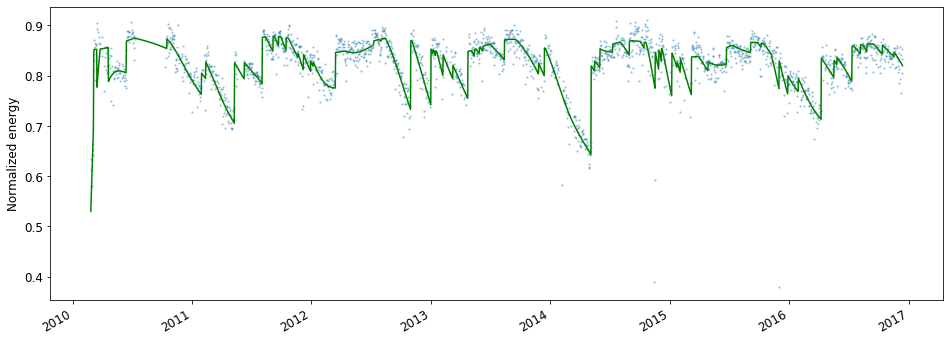

In [21]:
result_df = cods_instance.result_df
cods_model_fit = result_df.total_model

fig, ax = plt.subplots(figsize=(16,6))
ax.plot(soiled_daily.index, soiled_daily_filtered, 'o', alpha = 0.5)
ax.plot(cods_model_fit.index, cods_model_fit, color='g')
#ax.set_ylim(0,1.25)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

In [22]:
cods_degradation = cods_instance.degradation
print('The P50 degradation rate is {:.2f} %/yr'.format(cods_degradation[0]))
print('The 95 % confidence interval is ({:.2f}, {:.2f}) %/yr'.format(cods_degradation[1], cods_degradation[2]))

The P50 degradation rate is -0.35 %/yr
The 95 % confidence interval is (-0.63, -0.08) %/yr


RMSE of CODS:  0.023099732525934707
RMSE of SRR:  0.040491073487271094
MSD of CODS:  -0.0014996878378635487
MSD of SRR:  0.00094490020737861


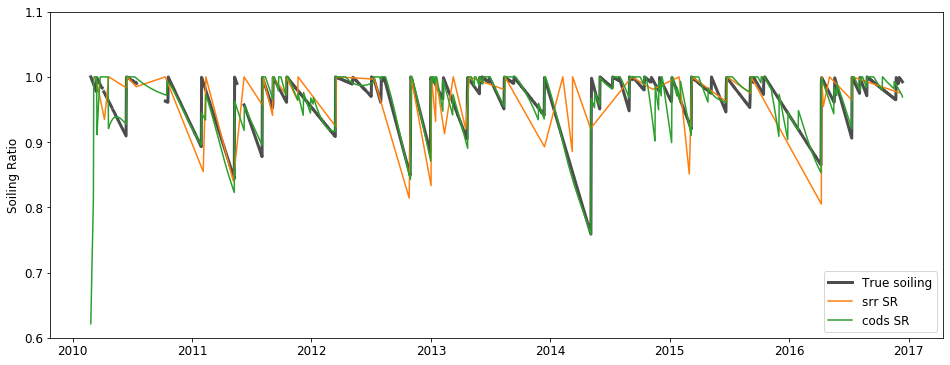

In [48]:
cods_soiling_ratio = result_df.soiling_ratio
srr_soiling_ratio = soiling_info['soiling_ratio_perfect_clean']

plt.figure(figsize=(16,6))
plt.plot(soiling.index, soiling, '.3', label='True soiling', linewidth=3)
plt.plot(srr_soiling_ratio.index, srr_soiling_ratio, color='C1', label='srr SR')
plt.plot(cods_soiling_ratio.index, cods_soiling_ratio, color='C2', label='cods SR')
plt.ylabel('Soiling Ratio')
plt.ylim(.6, 1.1)
plt.legend()

print('RMSE of CODS: ', np.sqrt(np.mean((cods_soiling_ratio - soiling)**2)))
print('RMSE of SRR: ', np.sqrt(np.mean((srr_soiling_ratio - soiling)**2)))
print('MSD of CODS: ', np.mean(cods_soiling_ratio - soiling))
print('MSD of SRR: ', np.mean(srr_soiling_ratio - soiling))

In [24]:
# Soiling loss (SL) is the percentage energy loss caused by soiling, i.e. SR = 1 - SL / 100
cods_avg_soiling_ratio = 1 - np.array(cods_instance.soiling_loss) / 100
print('The P50 avg soiling ratio {:.3f} %'.format(cods_avg_soiling_ratio[0]))
print('The 95 % confidence interval is ({:.3f}, {:.3f}) %'.format(cods_avg_soiling_ratio[2], cods_avg_soiling_ratio[1]))

The P50 avg soiling ratio 0.959 %
The 95 % confidence interval is (0.947, 0.969) %


## Clear sky workflow
The clear sky workflow is useful in that it avoids problems due to drift or recalibration of ground-based sensors. We use `pvlib` to model the clear sky irradiance. This is renormalized to align it with ground-based measurements. Finally we use `rdtools.get_clearsky_tamb()` to model the ambient temperature on clear sky days. This modeled ambient temperature is used to model cell temperature with `pvlib`. If high quality ambient temperature data is available, that can be used instead of the modeled ambient; we proceed with the modeled ambient temperature here for illustrative purposes.

In this example, note that we have omitted wind data in the cell temperature calculations for illustrative purposes. Wind data can also be included when the data source is trusted for improved results

We generally recommend that the clear sky workflow be used as a check on the sensor workflow. It tends to be more sensitive than the sensor workflow, and thus we don't recommend it as a stand-alone analysis.

**Note that the calculations below rely on some objects from the steps above**

## Clear Sky 0: Preliminary Calculations

In [25]:
# Calculate the clear sky POA irradiance
clearsky = loc.get_clearsky(df.index, solar_position=sun)

cs_sky = pvlib.irradiance.isotropic(meta['tilt'], clearsky.dhi)
cs_beam = pvlib.irradiance.beam_component(meta['tilt'], meta['azimuth'],
                                          sun.zenith, sun.azimuth, clearsky.dni)
df['clearsky_poa'] = cs_beam + cs_sky

# Renormalize the clear sky POA irradiance
df['clearsky_poa'] = rdtools.irradiance_rescale(df.poa, df.clearsky_poa,
                                                method='iterative')

# Calculate the clearsky temperature
df['clearsky_Tamb'] = rdtools.get_clearsky_tamb(df.index, meta['latitude'],
                                                meta['longitude'])
df['clearsky_Tcell'] = pvlib.temperature.sapm_cell(df.clearsky_poa, df.clearsky_Tamb,
                                                   0, **meta['temp_model_params'])

C:\Users\asmunds\AppData\Local\Continuum\anaconda3\envs\NRELenv\lib\site-packages\pandas\core\indexes\base.py:3071: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  target = np.asarray(target)


## Clear Sky 1: Normalize
Normalize as in step 1 above, but this time using clearsky modeled irradiance and cell temperature

In [26]:
# Calculate the expected power with a simple PVWatts DC model
clearsky_modeled_power = pvlib.pvsystem.pvwatts_dc(df['clearsky_poa'],
                                                   df['clearsky_Tcell'],
                                                   meta['pdc'], meta['tempco'], 25.0 )

# Calculate the normalization, the function also returns the relevant insolation for
# each point in the normalized PV energy timeseries
clearsky_normalized, clearsky_insolation = rdtools.normalize_with_expected_power(
    df['power'],
    clearsky_modeled_power,
    df['clearsky_poa']
)

df['clearsky_normalized'] = clearsky_normalized
df['clearsky_insolation'] = clearsky_insolation

## Clear Sky 2: Filter
Filter as in step 2 above, but with the addition of a clear sky index (csi) filter so we consider only points well modeled by the clear sky irradiance model.

In [27]:
# Perform clearsky filter
cs_normalized_mask = rdtools.normalized_filter(df['clearsky_normalized'])
cs_poa_mask = rdtools.poa_filter(df['clearsky_poa'])
cs_tcell_mask = rdtools.tcell_filter(df['clearsky_Tcell'])

csi_mask = rdtools.csi_filter(df.insolation, df.clearsky_insolation)

clearsky_filtered = df[cs_normalized_mask & cs_poa_mask & cs_tcell_mask &
                       clip_mask & csi_mask]
clearsky_filtered = clearsky_filtered[['clearsky_insolation', 'clearsky_normalized']]

## Clear Sky 3: Aggregate
Aggregate the clear sky version of of the filtered data 

In [28]:
clearsky_daily = rdtools.aggregation_insol(clearsky_filtered.clearsky_normalized,
                                           clearsky_filtered.clearsky_insolation)

## Clear Sky 4: Degradation Calculation
Estimate the degradation rate and compare to the results obtained with sensors. In this case, we see that the degradation rate estimated with the clearsky methodology is not far off from the sensor-based estimate. 

The P95 exceedance level with the clear sky analysis is -0.91%/yr


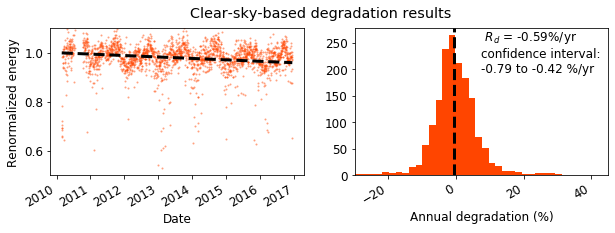

In [29]:
# Calculate the degradation rate using the YoY method
cs_yoy_rd, cs_yoy_ci, cs_yoy_info = rdtools.degradation_year_on_year(
    clearsky_daily,
    confidence_level=68.2
)

# Note the default confidence_level of 68.2 is appropriate if you would like to 
# report a confidence interval analogous to the standard deviation of a normal
# distribution. The size of the confidence interval is adjustable by setting the
# confidence_level variable.

# Visualize the results
clearsky_fig = rdtools.degradation_summary_plots(
    cs_yoy_rd, cs_yoy_ci, cs_yoy_info, clearsky_daily,
    summary_title='Clear-sky-based degradation results',
    scatter_ymin=0.5, scatter_ymax=1.1,
    hist_xmin=-30, hist_xmax=45, plot_color='orangered',
    bins=100);

print('The P95 exceedance level with the clear sky analysis is %.2f%%/yr' %
      cs_yoy_info['exceedance_level'])

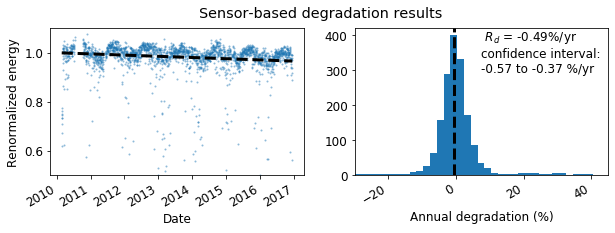

In [30]:
# Compare to previous sensor results
degradation_fig

## CODS on clearsky data

In [31]:
# Filtering clearsky_daily
clearsky_daily_filtered = clearsky_daily.copy()
rm_clearsky_daily = clearsky_daily.rolling(7, 3, center=True).median()
rm_residuals = clearsky_daily - rm_clearsky_daily
upper_outliers, lower_outliers = rdtools.soiling.find_numeric_outliers(
    rm_residuals.dropna(), 3, verbose=False)
outliers = ~(~upper_outliers * ~lower_outliers * clearsky_daily > 0.1)
clearsky_daily_filtered[outliers] = np.nan

# Initialize a CODS instance
cs_cods_instance = rdtools.soiling.cods_analysis(clearsky_daily_filtered)

# Run CODS
cs_cods_instance.run_bootstrap(256, verbose=False)

Soiling signal is small relative to the noise.Iterative decomposition not possible.
Degradation found by RdTools YoY


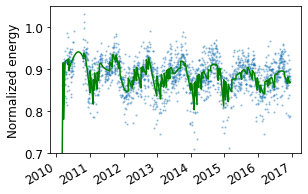

In [32]:
cs_result_df = cs_cods_instance.result_df
cs_cods_model_fit = cs_result_df.total_model

fig, ax = plt.subplots()
ax.plot(clearsky_daily_filtered.index, clearsky_daily_filtered, 'o', alpha = 0.5)
ax.plot(cs_cods_model_fit.index, cs_cods_model_fit, color='g')
ax.set_ylim(.7,1.05)
fig.autofmt_xdate()
ax.set_ylabel('Normalized energy');

In [33]:
cs_cods_degradation = cs_cods_instance.degradation
print('The P50 degradation rate is {:.2f} %/yr'.format(cs_cods_degradation[0]))
print('The 95 % confidence interval is ({:.2f}, {:.2f}) %/yr'.format(cs_cods_degradation[1], cs_cods_degradation[2]))

The P50 degradation rate is -0.65 %/yr
The 95 % confidence interval is (-0.87, -0.48) %/yr
